# Text Generation

### Import Libs

In [1]:
# ! pip install -U pip

In [2]:
# ! pip install -U torchtext

In [3]:
# ! python3 -m spacy download en_core_web_sm

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from typing import Optional, Sequence
from random import sample
from collections import Counter
from IPython.display import clear_output
import spacy

import torch
import torchtext
import torch.nn.functional as F
from torch import nn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [5]:
torchtext.__version__

'0.11.2'

### Options

In [6]:
! nvidia-smi

Sat Jan  7 20:29:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:06.0 Off |                    0 |
| N/A   27C    P8     8W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
torch.cuda.is_available()

True

## 1. Generating names with RNN

### Data

In [8]:
START_TOKEN, PAD_TOKEN = "_", " "

In [9]:
def read_names(filename: str, start_token: str = START_TOKEN):
    with open(filename) as file:
        return [start_token + line.strip() for line in file]

In [10]:
names = read_names("./data/names.txt")

In [11]:
print(f"n samples = {len(names)}\n")

for name in names[::1000]:
    print(name)

n samples = 7944

_Abagael
_Claresta
_Glory
_Liliane
_Prissie
_Geeta
_Giovanne
_Piggy


Max length = 16


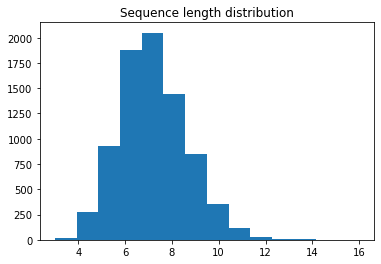

In [12]:
lengths = list(map(len, names))
MAX_LENGTH = max(lengths)
print(f"Max length = {MAX_LENGTH}")

plt.title("Sequence length distribution")
plt.hist(lengths, bins=14)
plt.show()

### Text Processing

In [13]:
tokens_set = set()

for name in names:
    tokens_set.update(name)

tokens = sorted(tokens_set)  # list of all unique characters in the dataset

num_tokens = len(tokens)
print(f"num_tokens = {num_tokens}")

num_tokens = 56


In [14]:
# dictionary of symbol -> its identifier (index in tokens list)
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [15]:
def to_matrix(
    names: Sequence[str],
    max_len: Optional[int] = None,
    pad: int = token_to_id[PAD_TOKEN],
    dtype=np.int64,
    batch_first: bool = True,
):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, names))
    names_ix = np.full((len(names), max_len), pad, dtype)

    for i, name in enumerate(names):
        line_ix = [token_to_id[char] for char in name]
        names_ix[i, : len(line_ix)] = line_ix

    if not batch_first:  # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [16]:
names[:2]

['_Abagael', '_Abagail']

In [17]:
# Example: cast 4 random names to matrices, pad with zeros
print("\n".join(names[::2000]))
print(to_matrix(names[::2000]))

_Abagael
_Glory
_Prissie
_Giovanne
[[29  3 31 30 36 30 34 41  0]
 [29  9 41 44 47 54  0  0  0]
 [29 18 47 38 48 48 38 34  0]
 [29  9 38 44 51 30 43 43 34]]


In [18]:
to_matrix(names).shape

(7944, 16)

### Recurrent neural network

In [19]:
emb_test = nn.Embedding(num_tokens, 7)  # One hot + Linears

In [20]:
emb_test

Embedding(56, 7)

In [21]:
example_batch = torch.from_numpy(to_matrix([" Den", " Jhon"])).type(torch.int64)

In [22]:
example_batch

tensor([[ 0,  6, 34, 43,  0],
        [ 0, 12, 37, 44, 43]])

In [23]:
emb = emb_test(example_batch)
emb.shape

torch.Size([2, 5, 7])

In [24]:
emb

tensor([[[ 1.6838, -1.0490, -0.5832,  0.3200, -0.0232,  1.3732, -0.6594],
         [-0.3881, -0.2027,  0.4054, -0.0751,  0.3991,  0.3299, -0.2467],
         [-1.2962,  1.0457,  0.4049, -0.3399,  0.4504, -0.1575,  0.0908],
         [ 0.5345,  1.4602, -0.7628,  1.5168, -1.2187, -0.4914,  1.3891],
         [ 1.6838, -1.0490, -0.5832,  0.3200, -0.0232,  1.3732, -0.6594]],

        [[ 1.6838, -1.0490, -0.5832,  0.3200, -0.0232,  1.3732, -0.6594],
         [-0.6124,  0.2114,  0.8387, -0.9718, -2.0378,  1.1948,  0.2647],
         [-1.1064, -2.1416,  1.0035,  1.6814,  0.0804, -0.5796, -0.7954],
         [ 0.2395, -0.6193, -0.4243, -0.7002, -0.3605, -0.2415, -1.9550],
         [ 0.5345,  1.4602, -0.7628,  1.5168, -1.2187, -0.4914,  1.3891]]],
       grad_fn=<EmbeddingBackward0>)

In [25]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """

    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)

        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next)

        # compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [26]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [27]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(F.log_softmax(logits, -1))

    return torch.stack(logprobs, dim=1)

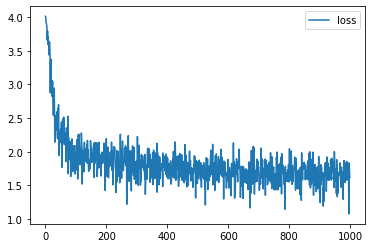

In [28]:
for i in range(1000):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)

    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #     print(predictions_logp.shape, actual_next_tokens.shape)
    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1),
    )

    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.item())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [29]:
def generate_sample(char_rnn, seed_phrase=START_TOKEN, max_length=MAX_LENGTH, temperature=1.0):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    # feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [30]:
for _ in range(10):
    print(generate_sample(char_rnn, seed_phrase="_", temperature=1.0))

_Anecie         
_Fabaley        
_Jeage          
_Derrile        
_Dotderade      
_Kasorna        
_Gil            
_Andic          
_Taverlie       
_Snax           


In [31]:
for _ in range(20):
    print(generate_sample(char_rnn, seed_phrase="_Al"))

_Ally           
_Albina    n    
_Alseline       
_Aletia         
_Alia           
_Alest          
_Alleon         
_Alaftine       
_Albia          
_AlB            
_Aloria         
_Alimzl         
_Alemtina       
_Almanel        
_Alicka         
_Alel           
_Althzelt       
_Alrines        
_Alia           
_Alometha       


In [32]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.1))

_Alle           
_Allen          
_Alle           
_Allin          
_Alle           
_Maris          
_Allin          
_Allen          
_Allina         
_Alle           


In [33]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.num_units = rnn_num_units

    def forward(self, x):
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

    def forward_char(self, x, h=None):
        if h is None:
            out, h = self.rnn(self.emb(x))
        else:
            out, h = self.rnn(self.emb(x), h)
        out = self.hid_to_logits(out)
        return out, h

    def initial_state(self, batch_size):
        """return rnn state before it processes first input (aka h0)"""
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [34]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

In [35]:
logp_seq = model(batch_ix)

loss = criterion(
    logp_seq[:, :-1].contiguous().view(-1, num_tokens), batch_ix[:, 1:].contiguous().view(-1)
)

loss.backward()

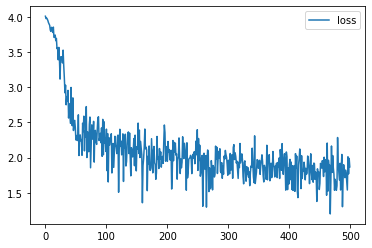

In [36]:
for i in range(500):
    opt.zero_grad()

    batch_ix = to_matrix(sample(names, 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens), actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label="loss")
        plt.legend()
        plt.show()

In [37]:
def generate_sample_lstm(
    char_rnn, seed_phrase=START_TOKEN, max_length=MAX_LENGTH, temperature=1.0, device=None
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # feed the seed phrase, if any
    logits, h = char_rnn.forward_char(x_sequence)
    logits = logits[:, -1]

    # start generating
    for _ in range(max_length - x_sequence.shape[1] + 1):
        p_next = F.softmax(logits / temperature, dim=-1).cpu().data.numpy().squeeze()

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        logits, h = char_rnn.forward_char(next_ix, h)

    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

In [38]:
for _ in range(10):
    print(generate_sample_lstm(model, temperature=1.0))

_Hesoha          
_Lasiance        
_Bamenn          
_Aullelis        
_Berklmaea       
_Eby             
_E elen          
_Jay             
_Chail           
_Narlial         


## 2. Generating poetry with RNN

### Data

In [39]:
# Downloading the text file containing poem sample
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt -O ./data/poetry.txt 

--2023-01-07 20:29:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.205.128, 64.233.165.128, 64.233.162.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.205.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘./data/poetry.txt’

./data/poetry.txt   100%[===================>]  67.35K  --.-KB/s    in 0.04s   

2023-01-07 20:29:32 (1.80 MB/s) - ‘./data/poetry.txt’ saved [68970/68970]



In [40]:
data = open('./data/poetry.txt').read()
sent_corpus = data.lower().split("\n")

sent_corpus[:5] # few sample lines of poem

['come all ye maidens young and fair',
 'and you that are blooming in your prime',
 'always beware and keep your garden fair',
 'let no man steal away your thyme',
 'for thyme it is a precious thing']

In [41]:
def build_vocab(corpus, tokenizer):
    counter = Counter()
    for text in corpus:
        counter.update(tokenizer(text))
        
    return vocab(counter, min_freq=1) 

In [42]:
# building a vocabulary and tokenizer
# nlp = spacy.load("en_core_web_sm")
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
vocabulary = build_vocab(sent_corpus, tokenizer)

In [43]:
symb = '<pad>'
if symb not in vocabulary: 
    vocabulary.insert_token(symb, 0)

In [44]:
len(vocabulary)

2682

In [45]:
def data_process(corpus, vocabulary):
    data = list()
    for text in corpus:
        token_list = [vocabulary.get_stoi()[token] for token in tokenizer(text)]
        for i in range(1, len(token_list)):
            n_gram_seq = torch.tensor(token_list[:i+1], dtype=torch.long)
            data.append(n_gram_seq)
    return data

In [46]:
train_data = data_process(sent_corpus, vocabulary)

In [47]:
train_data[:10] 

[tensor([1, 2]),
 tensor([1, 2, 3]),
 tensor([1, 2, 3, 4]),
 tensor([1, 2, 3, 4, 5]),
 tensor([1, 2, 3, 4, 5, 6]),
 tensor([1, 2, 3, 4, 5, 6, 7]),
 tensor([6, 8]),
 tensor([6, 8, 9]),
 tensor([ 6,  8,  9, 10]),
 tensor([ 6,  8,  9, 10, 11])]

In [48]:
X = [i[:-1] for i in train_data]   # taking all the words except the last in the input set
y = [i[-1] for i in train_data]    # taking last words in the output set

In [49]:
X[3], y[3]

(tensor([1, 2, 3, 4]), tensor(5))

In [50]:
X = pad_sequence(X, batch_first=True, padding_value=vocabulary.get_stoi()['<pad>'])   # padding the text_seq so the training sample are of equal length
y = torch.from_numpy(np.array(y))

In [51]:
train_data = TensorDataset(X, y)

In [52]:
BATCH_SIZE = 32

In [53]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [54]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

### LSTM

In [55]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, X, h=None, c=None):
        if h is None:
            h, c = self.init_state(X.size(0))
        out = self.embedding(X)
        out, (h, c) = self.lstm(out, (h, c))
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc1(out)
        out = out.view(-1, X.size(1), self.vocab_size)
        out = out[:, -1]
        
        return out, h, c
    
    def init_state(self, batch_size):
        num_l = self.num_layers
        hidden = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        cell = torch.zeros(num_l, batch_size, self.hidden_size).to(DEVICE)
        return hidden, cell

In [56]:
VOCAB_SIZE = len(vocabulary)
EMBEDDING_DIM = 128
HIDDEN_SIZE = 128
NUM_LAYERS = 3

In [57]:
model = Net(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE, NUM_LAYERS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [58]:
EPOCHS = 100

for epoch in range(EPOCHS):
    epoch_loss = 0
    for X, y in train_dataloader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        
        optimizer.zero_grad()
        output, h, c = model(X)
        loss = criterion(output, y)
        epoch_loss += loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # Clipping Gradients
        optimizer.step()
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1} Loss:{epoch_loss/len(train_dataloader)}") 

Epoch: 1 Loss:6.564174652099609
Epoch: 11 Loss:5.049520492553711
Epoch: 21 Loss:3.6454923152923584
Epoch: 31 Loss:2.6389143466949463
Epoch: 41 Loss:1.867517352104187
Epoch: 51 Loss:1.3258310556411743
Epoch: 61 Loss:0.9815443754196167
Epoch: 71 Loss:0.7858065366744995
Epoch: 81 Loss:0.6853952407836914
Epoch: 91 Loss:0.6295480132102966


### Generating the Poem

In [62]:
seed_text = "you should up" #Starting of a song
next_words = 50

for i in range(next_words):
    token_list = np.ones(21, dtype=int)
    text_token = np.array([vocabulary.get_stoi()[token] for token in tokenizer(seed_text)])
    if len(text_token)>21:text_token = text_token[-21:]
    token_list[:len(text_token)] = text_token
    token_list = torch.from_numpy(token_list).unsqueeze(0).to(DEVICE)
    
    
    out,h,c = model(token_list)
    
    idx = torch.argmax(out)
    seed_text += " " + vocabulary.get_itos()[idx]
    
for i,word in enumerate(seed_text.split()):
    print(word,end=" "),
    if i!=0 and (i+1)%5==0:
        print("\n")

you should up accident . 

accident accident , accident , 

wishful crúite crúite accident piper 

fame roof recall diamonds armless 

prouder prouder danes armless armless 

armless armless accident armless armless 

accident prouder armless armless armless 

accident prouder prouder prouder prouder 

armless armless prouder sweethearts armless 

accident prouder prouder prouder accident 

cry prouder prouder 